In [23]:
import requests
import matplotlib.pyplot as plt
import json
import moviepy.editor as mp
from scipy.signal import argrelextrema
import matplotlib.image as mpimg
import imutils
import moviepy.editor as mp
import codecs
import base64
from PIL import Image
import numpy as np
from copy import copy
import xgboost as xgb
%matplotlib inline
from scipy.io import wavfile 
from scipy.fftpack import fft
import sys
import os
import librosa
#reload(sys)
#sys.setdefaultencoding("utf-8")

In [31]:
main_folder = '/home/arcady/Downloads/LibriSpeech/dev-other'
people = os.listdir(main_folder)
for man in people:
    man_audio = None
    man_folder = os.path.join(main_folder, man)
    subfolders = os.listdir(man_folder)
    for subfolder in subfolders:
        subfolder_path = os.path.join(man_folder, subfolder)
        files = os.listdir(subfolder_path)
        for file in files:
            if '.wav' in file:
                sampFreq, sample_audio = wavfile.read(os.path.join(subfolder_path, file))
                #print file, sampFreq, sample_audio, sample_audio.shape[0], sample_audio.shape[0] / float(sampFreq)
                if not isinstance(man_audio, np.ndarray):
                    man_audio = np.copy(sample_audio)
                else:
                    man_audio = np.hstack([man_audio, np.copy(sample_audio)])
                #print man_audio.shape
    print man,man_audio.shape[0] / sampFreq
    librosa.output.write_wav('/home/arcady/Downloads/LibriSpeech/people/%s.wav' % man, man_audio.astype(np.float32), sampFreq, norm=True)

2506 511
4570 606
700 600
116 601
1701 601
4515 600
4323 601
1585 601
4572 616
6123 603
4153 600
8288 399
3915 619
5543 604
8254 602
6599 181
1651 271
6467 602
1630 603
3663 608
6267 603
4831 604
7697 604
3660 615
7641 601
6455 428
1686 606
7601 610
5849 600
8173 313
6841 603
1650 604
1255 601


In [104]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet50 import preprocess_input, ResNet50
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Convolution1D, Convolution2D, MaxPooling2D, MaxPooling1D, GlobalMaxPooling1D, GlobalMaxPooling2D, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import optimizers, Input
from keras import backend as K

In [292]:
def create_features(folder, MFCC_SIZE):
    people_files = os.listdir(folder)
    mean,maxi = np.zeros((MFCC_SIZE)), np.zeros((MFCC_SIZE))
    cnt = 0
    
    for file in people_files:
        if file=='features':
            continue
        sampFreq, audio = wavfile.read(os.path.join(folder,file))
        audio = audio.astype(np.float32)
        print (sampFreq, np.max(audio))
        mfcc = librosa.feature.mfcc(y=audio, sr=sampFreq, n_mfcc=MFCC_SIZE)
        mfcc = mfcc.T.astype(np.float32)
        print (file, mfcc.shape)
        mfcc.tofile(os.path.join(folder, 'features/'+file.replace('wav', 'dat')))
        if not 'test' in file:
            mean += np.mean(mfcc, axis = 0)
            for i in range(maxi.shape[0]):
                maxi[i] = max(maxi[i],np.max(np.abs(mfcc[:,i])))
            cnt += 1
            
    mean /= cnt
    
    for file in people_files:
        if file=='features':
            continue
        features = np.fromfile(os.path.join(folder, 'features/'+file.replace('wav', 'dat')), dtype = np.float32)
        features = features.reshape(features.shape[0] / MFCC_SIZE, MFCC_SIZE)
        features -= mean
        features /= maxi
        print (file, np.mean(features,axis=0), np.max(features, axis=0))
        features.tofile(os.path.join(folder, 'features/'+file.replace('wav', 'dat')))

In [293]:
MFCC_SIZE = 30

In [294]:
create_features('/home/arcady/Downloads/LibriSpeech/people', MFCC_SIZE)

(16000, 0.96888924)
('7601.wav', (19079, 30))
(16000, 1.0)
('4153.wav', (18761, 30))
(16000, 0.95678413)
('8288.wav', (12495, 30))
(16000, 0.66443366)
('6123.wav', (18863, 30))
(16000, 1.0)
('700.wav', (18761, 30))
(16000, 1.0)
('1651.wav', (8497, 30))
(16000, 0.99572855)
('6267.wav', (18858, 30))
(16000, 1.0)
('1650.wav', (18890, 30))
(16000, 1.0)
('2506.wav', (15978, 30))
(16000, 1.0)
('6841.wav', (18860, 30))
(16000, 0.60781646)
('5849.wav', (18759, 30))
(16000, 0.79673183)
('4572.wav', (19274, 30))
(16000, 0.99721825)
('4515.wav', (18756, 30))
(16000, 0.99948806)
('1686.wav', (18955, 30))
(16000, 0.94734263)
('5543.wav', (18888, 30))
(16000, 0.82539284)
('8254.wav', (18844, 30))
(16000, 1.0)
('6455.wav', (13396, 30))
(16000, 0.98014748)
('3663.wav', (19001, 30))
(16000, 1.0)
('1630.wav', (18855, 30))
(16000, 1.0)
('8173.wav', (9800, 30))
(16000, 0.99996948)
('1255.wav', (18803, 30))
(16000, 1.0)
('3915.wav', (19358, 30))
(16000, 32767.0)
('test3.wav', (5219, 30))
(16000, 1.0)
('764

('5849.wav', array([-0.1039485 ,  0.02138849, -0.03946969,  0.00872124, -0.10938704,
       -0.09737082, -0.01806062, -0.09425893, -0.01798598, -0.09306752,
       -0.02705442, -0.00969738, -0.04584486, -0.05833074,  0.00270686,
       -0.05185926, -0.03790405, -0.04454232, -0.05312378, -0.03207731,
       -0.04859659, -0.01883101,  0.03356253,  0.00406601,  0.04439481,
        0.05357784,  0.05325307,  0.03197755,  0.03321036,  0.03842412], dtype=float32), array([ 0.40312928,  0.62854218,  0.67860734,  0.5545091 ,  0.46255153,
        0.84673649,  0.61714047,  0.59175897,  0.74859047,  0.64983672,
        0.77958786,  0.7021302 ,  0.57690173,  0.50796086,  0.48109713,
        0.41764823,  0.3946563 ,  0.41016975,  0.44136903,  0.55465245,
        0.59537035,  0.69670212,  0.89506942,  0.95541608,  0.77965623,
        0.86477131,  0.79556441,  0.82891518,  0.80911821,  0.81754422], dtype=float32))
('4572.wav', array([ 0.1287775 ,  0.06970369,  0.0447363 ,  0.02942891,  0.03788348,
    

('1255.wav', array([-0.02471265, -0.14517254,  0.07349564,  0.00831817,  0.01923263,
        0.10434482,  0.02170482,  0.09049813,  0.03212048,  0.07866772,
        0.11054903,  0.01899382,  0.02979699,  0.10886751,  0.0303057 ,
        0.06072333,  0.06408479,  0.05020448,  0.02677302,  0.04477812,
        0.01719951,  0.00889081,  0.01354358,  0.01039285, -0.00640423,
        0.00639627,  0.00186956, -0.00097069, -0.00705752, -0.00291869], dtype=float32), array([ 0.60137838,  0.46975327,  0.69571644,  0.55211645,  0.40783256,
        0.58130318,  0.59696627,  0.55480289,  0.49729031,  0.67008066,
        0.89618087,  0.64674675,  0.54359359,  0.65992749,  0.45262596,
        0.45295051,  0.38945466,  0.41837397,  0.35915175,  0.39055505,
        0.57721198,  0.67594451,  0.7081489 ,  0.82774395,  0.87235808,
        0.81268287,  0.77844703,  0.9348188 ,  0.94099116,  0.73498333], dtype=float32))
('3915.wav', array([-0.00566511,  0.09325313,  0.06481528, -0.05445525, -0.01907107,
    

('test2.wav', array([ 1.8835876 ,  0.03231598,  0.066852  ,  0.02483342, -0.09047411,
        0.24044137, -0.1451875 ,  0.02667232, -0.20463808, -0.01584346,
       -0.1763643 , -0.12928796, -0.11125087, -0.02669831,  0.00467367,
       -0.17894015, -0.06655163,  0.02582625, -0.2319431 , -0.03748198,
       -0.05395519, -0.04434352, -0.03768548, -0.05075188, -0.07209051,
       -0.03895446, -0.06699429, -0.031118  , -0.06100481, -0.00273875], dtype=float32), array([ 2.09654737,  0.32762209,  0.37236542,  0.27124229,  0.07855422,
        0.53577209,  0.14016868,  0.29175887,  0.05843386,  0.35280171,
        0.1031139 ,  0.17913215,  0.16265708,  0.32029402,  0.45411217,
        0.18634556,  0.22710222,  0.29768261,  0.03002164,  0.17371936,
        0.1432289 ,  0.13986301,  0.14826651,  0.16685438,  0.09985109,
        0.21127233,  0.12142595,  0.14198157,  0.14593478,  0.17582318], dtype=float32))
('4570.wav', array([-0.00893165, -0.08684277, -0.06886128, -0.02264558,  0.00176383,
   

0


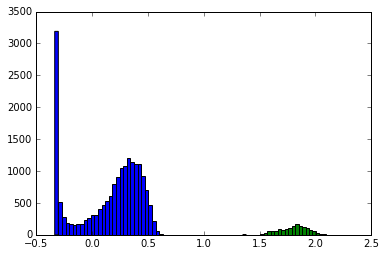

1


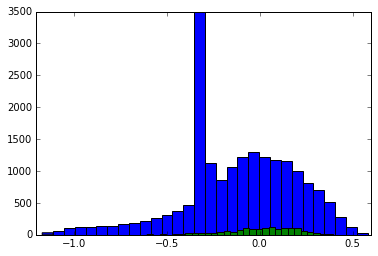

2


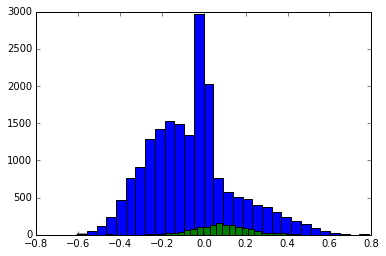

3


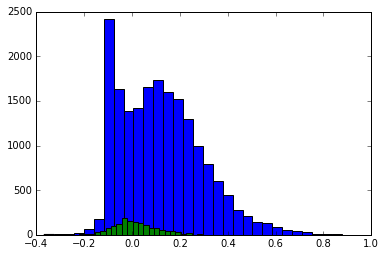

4


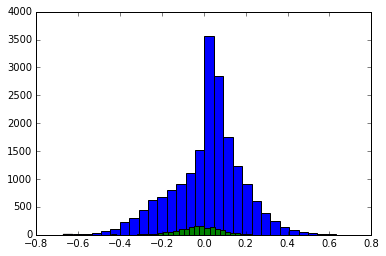

5


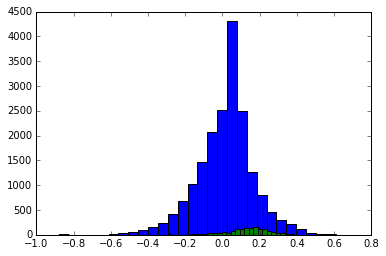

6


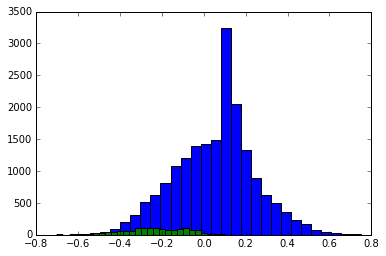

7


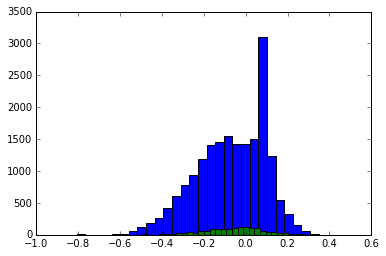

8


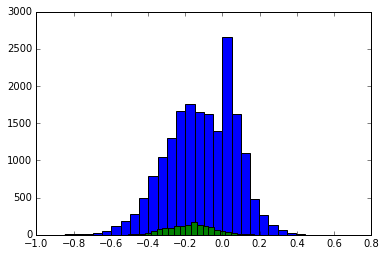

9


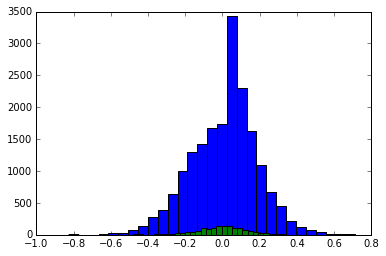

10


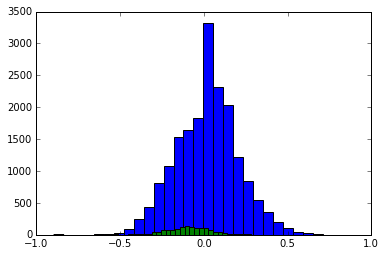

11


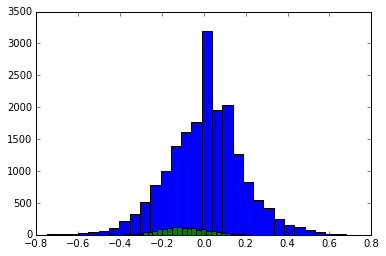

12


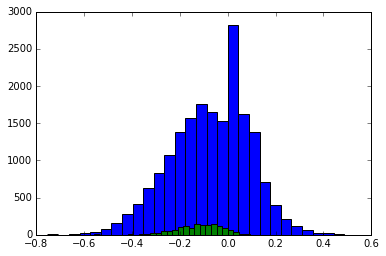

13


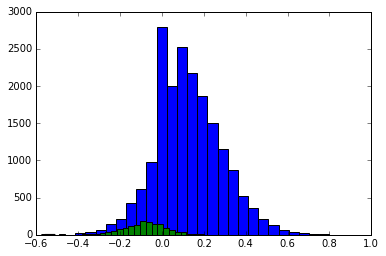

14


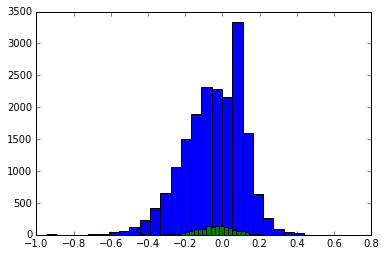

15


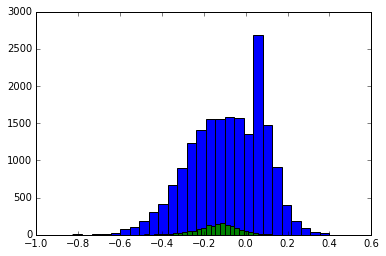

16


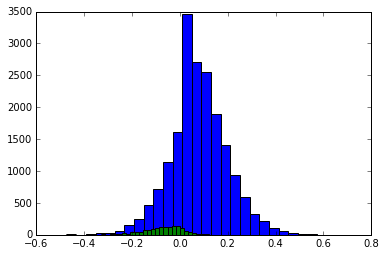

17


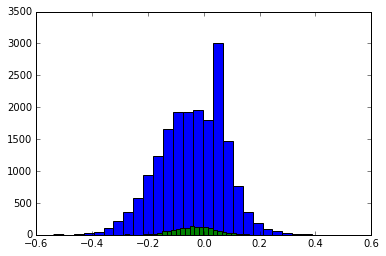

18


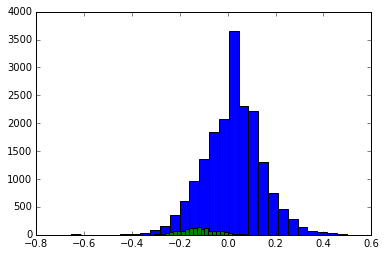

19


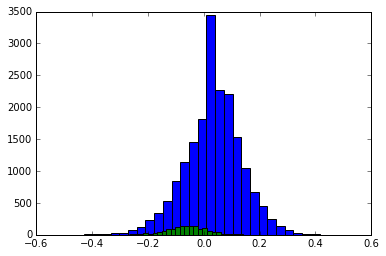

20


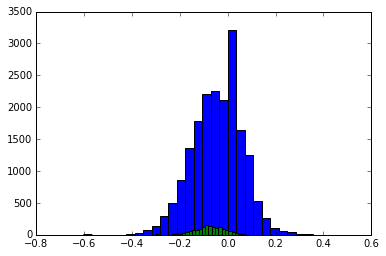

21


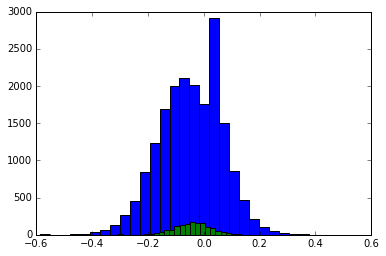

22


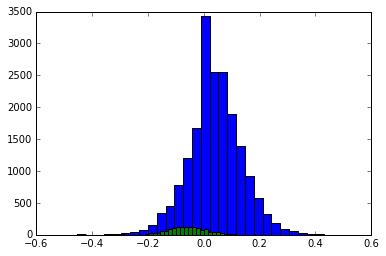

23


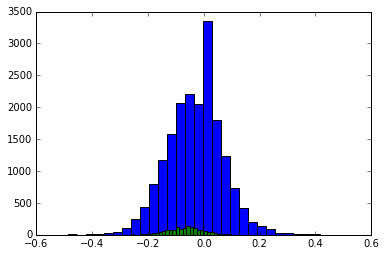

24


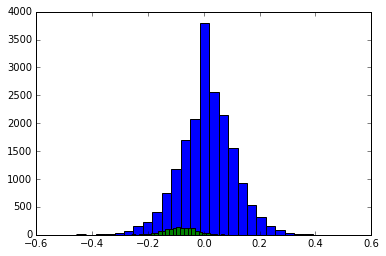

25


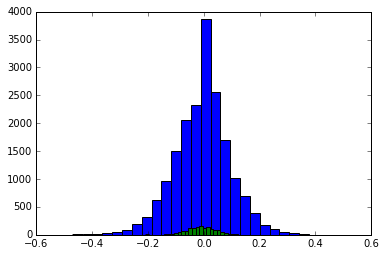

26


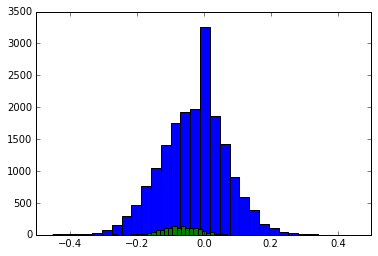

27


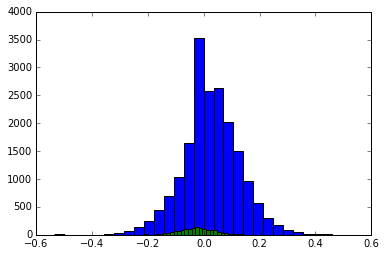

28


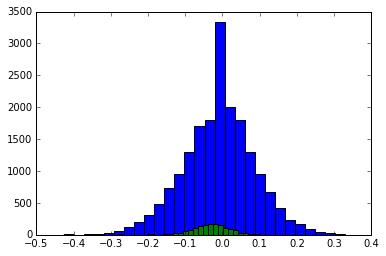

29


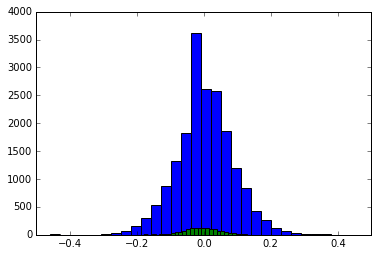

In [295]:
features1 = np.fromfile(os.path.join('/home/arcady/Downloads/LibriSpeech/people', 'features/'+'116.wav'.replace('wav', 'dat')), dtype = np.float32)
features1 = features1.reshape(features1.shape[0] / MFCC_SIZE, MFCC_SIZE)
features2 = np.fromfile(os.path.join('/home/arcady/Downloads/LibriSpeech/people', 'features/'+'test1.wav'.replace('wav', 'dat')), dtype = np.float32)
features2 = features2.reshape(features2.shape[0] / MFCC_SIZE, MFCC_SIZE)

for i in range(features1.shape[1]):
    print i
    plt.hist(features1[:,i], 30);
    plt.hist(features2[:,i], 30);
    plt.show()
good_set = [1,2,3,5,6,8,9,11,12,13,15,16,18,19,21,22,23,26,28,29]

In [283]:
len(good_set)

20

In [276]:
def create_sample_from_audio(file, sample_length, mfcc_size):
    features = np.fromfile(file, dtype = np.float32)
    features = features.reshape(features.shape[0]/mfcc_size, mfcc_size)[:, good_set]
    len = features.shape[0]
    i = np.random.randint(sample_length, len)
    return features[i - sample_length : i]

In [318]:
def batch_generator(folder, batch_size=32, sample_length = 100, mfcc_size = 20, validation = False):
    people_files = os.listdir(folder)
    if validation:
        #people_files = ['3660.dat', '3663.dat']
        people_files = [file for file in people_files if 'test' in file]
    else:
        #people_files = [file for file in people_files if 'test' not in file]
        people_files = ['test1.dat', 'test2.dat']
        #people_files.remove('3660.dat')
        #people_files.remove('3663.dat')
    
    print (people_files)
    
    while True:
        x_batch1, x_batch2, y_batch = [], [],[]
        for i in range(batch_size):
            if np.random.uniform(0,1) < 0.5: #from one man
                ind = np.random.randint(0, len(people_files))
                sample_part1 = create_sample_from_audio(os.path.join(folder, people_files[ind]), sample_length, mfcc_size)
                sample_part2 = create_sample_from_audio(os.path.join(folder, people_files[ind]), sample_length, mfcc_size)
                y = 1
            else: #from two different people
                ind = np.random.choice(len(people_files), 2)
                ind1, ind2 = ind[0], ind[1]    
                sample_part1 = create_sample_from_audio(os.path.join(folder, people_files[ind1]), sample_length, mfcc_size)
                sample_part2 = create_sample_from_audio(os.path.join(folder, people_files[ind2]), sample_length, mfcc_size)
                y = 0
                #if validation:
                #    print people_files[ind1], people_files[ind2]
                
            x_batch1.append(sample_part1)
            x_batch2.append(sample_part2)
            y_batch.append(y)
            
        x_batch1 = np.array(x_batch1)
        x_batch2 = np.array(x_batch2)
        #print (x_batch1.shape)
        x_batch1 = x_batch1.reshape(x_batch1.shape[0], x_batch1.shape[1], 1, x_batch1.shape[2])
        x_batch2 = x_batch2.reshape(x_batch1.shape[0], x_batch2.shape[1], 1, x_batch2.shape[2])
        y_batch = np.array(y_batch)
        #print (x_batch1.shape, y_batch.shape)
        #if validation:
        #    print (y_batch)
        yield [x_batch1, x_batch2], y_batch

In [319]:
def generate_model(sample_length, mfcc_features):
    inputs1 = Input(shape=(sample_length, 1, mfcc_features))
    inputs2 = Input(shape=(sample_length, 1, mfcc_features))
    
    conv_layer = Convolution2D(kernel_size=(mfcc_features,1), strides=(10,1), filters = 30, activation = 'relu')
    conv1 = conv_layer(inputs1)
    conv2 = conv_layer(inputs2)
    
    pool_layer = GlobalMaxPooling2D()
    pool1 = pool_layer(conv1)
    pool2 = pool_layer(conv2)
    
    merged = Concatenate()([pool1, pool2])
    #flatten = Flatten()(merged)
    classify = Dense(10, activation = 'sigmoid')(merged)
    classify = Dense(1, activation = 'sigmoid')(classify)
    model = Model(inputs=[inputs1, inputs2], outputs=classify)
    model.summary()
    return model

In [ ]:
SAMPLE_LENGTH = 480 #30 ms
MFCC_SIZE = 30
model = generate_model(SAMPLE_LENGTH, len(good_set))
model.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
model.fit_generator(batch_generator('/home/arcady/Downloads/LibriSpeech/people/features', 128, SAMPLE_LENGTH, MFCC_SIZE),
                   steps_per_epoch=300,
                   nb_epoch = 30,
                   validation_data = batch_generator('/home/arcady/Downloads/LibriSpeech/people/features', 32, SAMPLE_LENGTH, MFCC_SIZE, True),
                   validation_steps = 100)

  if __name__ == '__main__':

  if __name__ == '__main__':



____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_139 (InputLayer)           (None, 480, 1, 20)    0                                            
____________________________________________________________________________________________________
input_140 (InputLayer)           (None, 480, 1, 20)    0                                            
____________________________________________________________________________________________________
conv2d_47 (Conv2D)               (None, 47, 1, 30)     12030       input_139[0][0]                  
                                                                   input_140[0][0]                  
____________________________________________________________________________________________________
global_max_pooling2d_35 (GlobalM (None, 30)            0           conv2d_47[0][0]         

In [321]:
mfcc_size = 30
features = np.fromfile('/home/arcady/Downloads/LibriSpeech/people/features/test3.dat', dtype = np.float32)
features = features.reshape(features.shape[0]/mfcc_size, mfcc_size)[:, good_set]
preds = []
for i in range(0, features.shape[0]-SAMPLE_LENGTH, 10):
    sample = create_sample_from_audio('/home/arcady/Downloads/LibriSpeech/people/features/test1.dat', SAMPLE_LENGTH, mfcc_size)
    cur_test_part = features[i:i+SAMPLE_LENGTH]
    cur_test_part = cur_test_part.reshape(1, cur_test_part.shape[0], 1, cur_test_part.shape[1])
    sample = sample.reshape(1, sample.shape[0], 1, sample.shape[1])
    #print cur_test_part.shape, sample.shape
    print i, model.predict([sample, cur_test_part])[0,0]

0 0.265905
10 0.273774
20 0.251814
30 0.261298
40 0.26128
50 0.284464
60 0.273777
70 0.241697
80 0.245448
90 0.248814
100 0.282373
110 0.369729
120 0.433227
130 0.467276
140 0.46012
150 0.454632
160 0.422421
170 0.450028
180 0.446014
190 0.458712
200 0.447431
210 0.477371
220 0.442227
230 0.452796
240 0.452361
250 0.426538
260 0.466156
270 0.427672
280 0.456472
290 0.447003
300 0.450824
310 0.478591
320 0.500447
330 0.509481
340 0.493564
350 0.506083
360 0.486012
370 0.509673
380 0.519032
390 0.512742
400 0.492231
410 0.500642
420 0.510658
430 0.511251
440 0.523699
450 0.501422
460 0.49883
470 0.510888
480 0.52297
490 0.518484
500 0.479662
510 0.495842
520 0.489725
530 0.510888
540 0.500326
550 0.494448
560 0.505476
570 0.519503
580 0.489638
590 0.472506
600 0.486873
610 0.50795
620 0.503323
630 0.499728
640 0.494766
650 0.486197
660 0.484753
670 0.476965
680 0.482958
690 0.472263
700 0.493417
710 0.477901
720 0.466579
730 0.483479
740 0.474458
750 0.470148
760 0.489052
770 0.494002
78

In [303]:
features.shape

(5219, 20)